In [1]:
!pip install fastai
!pip install -U pyarrow

import numpy as np
import pandas as pd
import seaborn as sns

import requests
import ast
import os
import gc
import matplotlib.pyplot as plt

from fastai.vision import *
from fastai.metrics import error_rate, accuracy

Requirement already up-to-date: pyarrow in /usr/local/lib/python3.6/dist-packages (0.13.0)


In [0]:
# Will need to login to access the bucket. The following lines of code do just that
from google.colab import auth
auth.authenticate_user()

# List out all the files in the directory (Make sure that we are logged in)
gs_path = 'platform-ai-research/datasets/ProductNet/'
# !gsutil ls gs://{gs_path}

Run the following only once.

In [3]:
# # Pull from GS
# gs_path = 'platform-ai-research/datasets/ProductNet/'

# file_name = 'ProductNet_small_prediction_2.csv'
# remote_file = gs_path + file_name
# !gsutil cp gs://{remote_file} {file_name} 


# file_name = 'urls_20000'
# remote_file = gs_path + file_name
# !gsutil cp gs://{remote_file} {file_name} 

Copying gs://platform-ai-research/datasets/ProductNet/ProductNet_small_prediction_2.csv...
/ [1 files][ 38.2 KiB/ 38.2 KiB]                                                
Operation completed over 1 objects/38.2 KiB.                                     
Copying gs://platform-ai-research/datasets/ProductNet/urls_20000...
/ [1 files][  1.5 MiB/  1.5 MiB]                                                
Operation completed over 1 objects/1.5 MiB.                                      


Our final working `df` is `df_new_label`. It contains 784 entries and 10 classes. The folder we store the images is `images_784`. These can be found in the GS bucket.

Rerun from here after cleaning the labels.

In [0]:
# get the csv from platform.ai
pnet = pd.read_csv('ProductNet_small_prediction_2.csv')

# remove duplicates
pnet = pnet.drop_duplicates()

# create asin column
pnet['asin'] = pnet['file_name'].str.strip('.jpg')

# get the list of asins
pnet_asins = pnet['asin'].tolist()

# read in original urls df
urls_20000 = pd.read_feather('urls_20000')

# merge pnet with urls
final = pd.merge(pnet, urls_20000,
                 left_on='asin', right_on='asin',
                 how='inner')

In [5]:
len(pnet), len(final)

(785, 785)

In [0]:
# !mkdir images_784

In [0]:
# Pull images into new folder

imUrls = final['imUrl'].tolist()
asins = final['asin'].tolist()

for url_label_id in zip(imUrls, asins):
    url = url_label_id[0] # url of image
    asin = url_label_id[1] # asin of image
    
    filename = './images_784/' + asin + '.jpg'      
  
    # also check if file exists. If it does, do not reload it!
    if (not os.path.isfile(filename)):
        try:
            r = requests.get(url, allow_redirects=True)
            open(filename, 'wb').write(r.content)
            
        except Exception as e:
            final = final[final.asin != asin]           # if missing, remove from dataset
            with open("./missing_from_784.txt", "a") as f:
                f.write(asin+'\n')

In [0]:
from PIL import Image

for url_id in zip(imUrls, asins):
    url = url_id[0] # url of image
    asin = url_id[1] # asin of image
    
    filename = './images_784/' + asin + '.jpg'      
    
    try:
        img = Image.open(filename)
    except Exception as e:
        final = final[final.asin != asin]           # if missing, remove from dataset
        with open("./missing_imgs_784.txt", "a") as f:
            f.write(asin+'\n')

In [0]:
remove = ['B00IQHQQW0', 'B005FYG8PM', 'B005K2VQ6A', 
          'B00G6SDUYS', 'B001NH19BI', 'B004Q5G9WS', 
          'B003VBU172', 'B001BNNX4K'] # []

df = final[['asin', 'labeled_class']].copy()

df = df[~df['asin'].isin(remove)]

In [11]:
print('len of df:', len(df))

len of df: 777


In [0]:
np.random.seed(42)

tfms = get_transforms() # max_lighting=0.1, max_zoom=1.05, max_warp=0.

src = ImageDataBunch.from_df('./', 
                             df, 
                             folder='images_784', 
                             suffix='.jpg', 
                             ds_tfms=tfms, 
                             size=224, 
                             bs=64).normalize(imagenet_stats)

# src.show_batch(rows=3, figsize=(12,9))

In [0]:
# # print(src.classes)
# len(src.classes)

In [0]:
# df.head()

In [0]:
import os
import sys
from collections import OrderedDict
import torch
import torchvision
import torchvision.models
from torchvision.models import *
from torch.utils import model_zoo

In [0]:
x = 'https://bitbucket.org/robert_geirhos/texture-vs-shape-pretrained-models/raw/60b770e128fffcbd8562a3ab3546c1a735432d03/resnet50_finetune_60_epochs_lr_decay_after_30_start_resnet50_train_45_epochs_combined_IN_SF-ca06340c.pth.tar'

def custom_resnet(pretrained=False):
    model = torchvision.models.resnet50(pretrained=pretrained)
    model = torch.nn.DataParallel(model).cuda()    
    checkpoint = model_zoo.load_url(x)    
    model.load_state_dict(checkpoint["state_dict"])
    
    model = model.module   
    
    all_layers = list(model.children())    
        
    return nn.Sequential(*all_layers)

In [0]:
learn = cnn_learner(src, 
                    base_arch=custom_resnet,
                    cut=None,                    
                    pretrained=True,
                    metrics=error_rate)

In [33]:
# learn=None
gc.collect()

332

In [34]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,error_rate,time
0,2.268662,1.199131,0.309677,00:12
1,1.450166,0.416681,0.135484,00:12
2,1.037457,0.399803,0.135484,00:12
3,0.797842,0.391597,0.116129,00:12
4,0.637545,0.393484,0.103226,00:12
5,0.520835,0.369080,0.096774,00:12
6,0.431699,0.360432,0.122581,00:12
7,0.363831,0.354336,0.116129,00:12
8,0.313778,0.350734,0.122581,00:12
9,0.274054,0.352757,0.122581,00:12


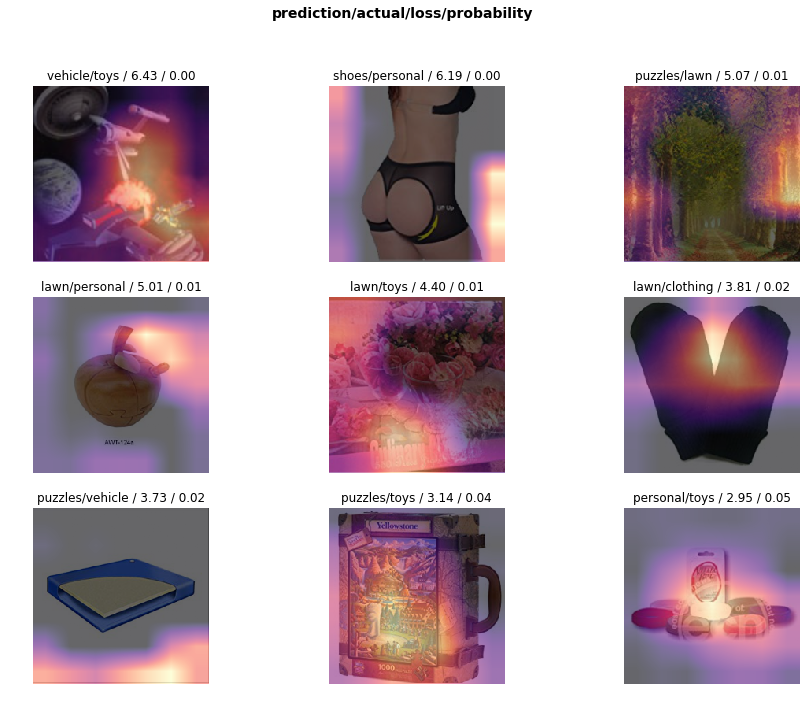

In [46]:
# interp_train = ClassificationInterpretation.from_learner(learn, 1)

interp_valid = ClassificationInterpretation.from_learner(learn)
interp_valid.plot_top_losses(9, figsize=(15,11))

Find the mislabeled `asin`.

In [0]:
# losses_train, idxs_train = interp_train.top_losses()
# losses_valid, idxs_valid = interp_valid.top_losses()

# train_bad_labels_idx = [idx for idx in idxs_train[:10]]
# valid_bad_labels_idx = [idx for idx in idxs_valid[:10]]

# train = src.train_ds.x.items[:]
# valid = src.valid_ds.x.items[:]

# train_bad_asin = []
# valid_bad_asin = []

# for idx in train_bad_labels_idx:
#     img_name_path = train[idx]
#     asin = str(img_name_path).strip('.jpg').strip('/images_784')
#     train_bad_asin.append(asin)
    
# for idx in valid_bad_labels_idx:
#     img_name_path = valid[idx]
#     asin = str(img_name_path).strip('.jpg').strip('/images_784')
#     valid_bad_asin.append(asin)
    
# bad = final[(final['asin'].isin(train_bad_asin)) |
#             (final['asin'].isin(valid_bad_asin))]

# bad    

# asins = bad['asin'].tolist()

# print(asins)

In [0]:
# # # use to check for bad labels
# remove = [4, 11, 16]

# drops = [asins[idx] for idx in remove]

# print(drops)

# # asin = asins[19]

# # filename = './images_784/' + asin + '.jpg'      

# # img = Image.open(filename)

# # img

In [0]:
learn.unfreeze()

In [39]:
gc.collect()

14914

In [40]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,error_rate,time
0,0.107702,0.598153,0.129032,00:14
1,0.107076,0.782946,0.129032,00:15
2,0.131918,1.040036,0.187097,00:15
3,0.152902,0.808645,0.200000,00:14
4,0.158718,0.920884,0.238710,00:15
5,0.160772,1.078117,0.206452,00:15
6,0.145378,0.682148,0.174194,00:14
7,0.137053,0.536614,0.161290,00:15
8,0.121812,0.480498,0.129032,00:14
9,0.107868,0.465541,0.116129,00:14


In [41]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


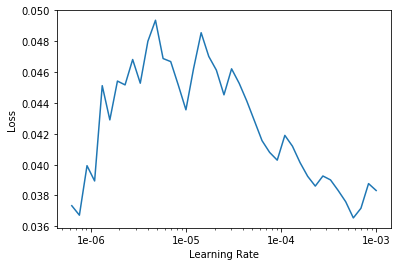

In [42]:
learn.recorder.plot()

In [0]:
learn.save('custom_resnet_before_lr')

In [43]:
learn.fit_one_cycle(10, 7e-5)

epoch,train_loss,valid_loss,error_rate,time
0,0.026171,0.448139,0.116129,00:15
1,0.033995,0.443988,0.122581,00:15
2,0.032625,0.429318,0.116129,00:15
3,0.030004,0.412078,0.090323,00:15
4,0.028724,0.402964,0.103226,00:15
5,0.025761,0.396994,0.096774,00:15
6,0.021612,0.395999,0.103226,00:15
7,0.018750,0.400417,0.103226,00:15
8,0.017728,0.395325,0.103226,00:15
9,0.017042,0.404220,0.103226,00:15


Code below is taken from the NYC cohort. Many thanks to them.

In [44]:
tta_mod = []
for i in np.arange(0.7, 1.4, 0.05):
   tta_mod.append((i, accuracy(*learn.TTA(scale=i))))

In [45]:
sorted(tta_mod, key=lambda e:e[1], reverse=True)

[(1.0000000000000002, tensor(0.9226)),
 (1.1000000000000003, tensor(0.9226)),
 (1.1500000000000004, tensor(0.9226)),
 (1.2500000000000004, tensor(0.9226)),
 (1.3500000000000005, tensor(0.9226)),
 (0.9000000000000001, tensor(0.9161)),
 (0.9500000000000002, tensor(0.9161)),
 (1.0500000000000003, tensor(0.9161)),
 (1.3000000000000005, tensor(0.9161)),
 (0.8500000000000001, tensor(0.9097)),
 (0.8, tensor(0.9032)),
 (1.2000000000000004, tensor(0.9032)),
 (0.75, tensor(0.8968)),
 (0.7, tensor(0.8839))]